In [1]:
import sympy as sp 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
import datetime
import thesis_rcparams
import moon_tidal_deviation as MTD
from matplotlib.patches import Ellipse

In [2]:
def set_up_figure(nrows=3):
    """
    Set up the figure for the plot
    """
    # set up the figure 
    ncols=2
    fig = plt.figure(figsize=(8.25-2, 11.67-3))
    gs = fig.add_gridspec(nrows, ncols, wspace=0, )
    
    axes = []
    for i in range(nrows-1):
        axes.append([])
        axes[i].append(fig.add_subplot(gs[i, 0]))
        axes[i].append(fig.add_subplot(gs[i, 1]))
    # Add the bottom row spanning both columns
    axes.append(fig.add_subplot(gs[nrows-1, :]))

    
    return fig, axes

In [3]:
def plot_frame_data(axes, sim_index, down_index, 
                   tidal_orbit, rotating_orbit, 
                   inertial_tidal_solution, inertial_rotating_solution, earthsOrbit,
                   tidal_force, tidal_force_magnitude, colors_tidal,
                   X, Y, PROPERTIES, update_axis_limits=True):
    """
    Plot a frame of the moon orbital simulation for both Earth-centered and inertial reference frames.
    
    Parameters:
    ----------
    axes : list
        List of axes to plot on, where axes[0][0] is Earth-centered and axes[0][1] is inertial frame
    sim_index : int
        Current simulation index
    down_index : int
        Starting index for orbital history
    tidal_orbit, rotating_orbit : ndarray
        Position data in Earth-centered frame
    inertial_tidal_solution, inertial_rotating_solution, earthsOrbit : ndarray
        Position data in inertial frame
    tidal_force : ndarray
        Tidal force vector field
    tidal_force_magnitude : ndarray
        Magnitude of tidal force at each point
    colors_tidal : ndarray
        Colors for the tidal force vectors
    X, Y : ndarray
        Meshgrid for vector field
    PROPERTIES : tuple
        Tuple containing plot properties: (AXIS1, AXIS2, PLOT_TIDAL, PLOT_NONTIDAL, SCAT_TIDAL, SCAT_NONTIDAL, QUIV_TIDAL, QUIV_CENTRIFUGAL)
    update_axis_limits : bool, optional
        Whether to update axis limits for inertial frame based on Earth position, default True
    """
    # Unpack properties
    AXIS1, AXIS2, PLOT_TIDAL, PLOT_NONTIDAL, SCAT_TIDAL, SCAT_NONTIDAL, QUIV_TIDAL, QUIV_CENTRIFUGAL = PROPERTIES
    
    # Earth-centered plot (rotating frame)
    axes[0].clear()
    axes[0].quiver(X.flatten(), Y.flatten(), 
                      tidal_force[0]/tidal_force_magnitude, tidal_force[1]/tidal_force_magnitude,
                      color=colors_tidal, **QUIV_TIDAL)
    axes[0].scatter(0, 0, color='tab:blue', label=None)
    axes[0].plot(tidal_orbit[0, down_index:sim_index+1], 
                    tidal_orbit[1, down_index:sim_index+1], **PLOT_TIDAL)
    axes[0].scatter(tidal_orbit[0, sim_index], tidal_orbit[1, sim_index], **SCAT_TIDAL)
    axes[0].plot(rotating_orbit[0, down_index:sim_index+1], 
                    rotating_orbit[1, down_index:sim_index+1], **PLOT_NONTIDAL)
    axes[0].scatter(rotating_orbit[0, sim_index], rotating_orbit[1, sim_index], **SCAT_NONTIDAL)
    axes[0].set(**AXIS1)
    
    # Inertial frame plot
    axes[1].clear()
    axes[1].plot(inertial_tidal_solution[0, down_index:sim_index+1], 
                    inertial_tidal_solution[1, down_index:sim_index+1], **PLOT_TIDAL)
    axes[1].scatter(inertial_tidal_solution[0, sim_index], 
                      inertial_tidal_solution[1, sim_index], **SCAT_TIDAL)
    axes[1].plot(inertial_rotating_solution[0, down_index:sim_index+1], 
                    inertial_rotating_solution[1, down_index:sim_index+1], **PLOT_NONTIDAL)
    axes[1].scatter(inertial_rotating_solution[0, sim_index], 
                      inertial_rotating_solution[1, sim_index], **SCAT_NONTIDAL)
    axes[1].plot(earthsOrbit[0, down_index:sim_index+1], 
                   earthsOrbit[1, down_index:sim_index+1], color='tab:blue')
    axes[1].scatter(earthsOrbit[0, sim_index], earthsOrbit[1, sim_index], 
                      color='tab:blue', label='Earth')
    
    if update_axis_limits:
        semi_major_axis = AXIS1["xlim"][1] - AXIS1["xlim"][0]
        AXIS2["xlim"] = (earthsOrbit[0, sim_index]-5*semi_major_axis, 
                        earthsOrbit[0, sim_index]+5*semi_major_axis)
        AXIS2["ylim"] = (earthsOrbit[1, sim_index]-5*semi_major_axis, 
                        earthsOrbit[1, sim_index]+5*semi_major_axis)
    
    axes[1].set(**AXIS2)
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    axes[1].tick_params(axis='y', pad=10)
    
    # Add legend - uncomment if needed
    # axes[0][1].legend(loc='upper right')
    
    return axes

In [4]:
def calculate_frame_forces(sim_index, G_val, M_sun, Dearth, unscaled_tidal_tensor_func, 
                          earthsOrbit, positions, omega_vec, tidal_solution, rotating_two_body_solution):
    """
    Calculate all forces and positions needed for plotting a frame at the given simulation index.
    
    Parameters:
    ----------
    sim_index : int
        Current simulation index
    G_val : float
        Gravitational constant value
    M_sun : float
        Sun's mass
    Dearth : float
        Earth-Sun distance
    unscaled_tidal_tensor_func : callable
        Function to calculate unscaled tidal tensor
    earthsOrbit : ndarray
        Earth's orbit data
    positions : ndarray
        Grid positions for vector field
    omega_vec : ndarray
        Angular velocity vector
    tidal_solution : OdeResult
        Solution for orbit with tidal forces
    rotating_two_body_solution : OdeResult
        Solution for orbit without tidal forces
        
    Returns:
    -------
    dict
        Dictionary containing all calculated values:
        - tidal_tensor: Tidal tensor at Earth's position
        - tidal_force: Tidal force at each grid position
        - tidal_force_magnitude: Magnitude of tidal force
        - centrifugalforce: Centrifugal force at each grid position
        - centrifugalforce_magnitude: Magnitude of centrifugal force
        - tidal_orbit: Moon orbit with tidal effects
        - rotating_orbit: Moon orbit without tidal effects
    """
    # Create the tidal tensor
    earth_pos = earthsOrbit[:, sim_index]
    earth_r = np.linalg.norm(earth_pos)
    tidal_tensor = (G_val*M_sun/Dearth**3) * unscaled_tidal_tensor_func(
        earth_r, earth_pos[0], earth_pos[1], earth_pos[2]
    )
    
    # Get the tidal tensor at each position
    tidal_force = tidal_tensor.dot(positions.T)
    
    # Evaluate the centrifugal force
    centrifugalforce = -np.cross(omega_vec, np.cross(omega_vec, positions)).T
    
    # Calculate force magnitudes
    tidal_force_magnitude = np.linalg.norm(tidal_force, axis=0)
    centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
    
    # Extract position data
    tidal_orbit = tidal_solution.y[0:3]
    rotating_orbit = rotating_two_body_solution.y[:3]
    
    return tidal_tensor,tidal_force,tidal_force_magnitude,centrifugalforce,centrifugalforce_magnitude,tidal_orbit,rotating_orbit
    

In [5]:
# width of the orbit back 
orbit_index_width = 45
# number of vectors to use in the vector field 
nvec = 20    

outdir = "../frames/"
os.makedirs(outdir, exist_ok=True)
t_span = (0, 4)
t_eval_n_points = 5000
t_eval = np.linspace(t_span[0], t_span[1], t_eval_n_points)

#### Animation params  set some animation parametes
FPS = 30
SECONDS_PER_UNIT_TIME = 24 # which is that six seconds go by for each year 
DURATION_IN_UNIT_TIME = t_eval[-1]
TOTAL_SIM_INDEXES = len(t_eval)
DURATION_IN_SECONDS = DURATION_IN_UNIT_TIME*SECONDS_PER_UNIT_TIME
TOTAL_FRAMES = int(DURATION_IN_SECONDS * FPS)
FRAMES_PER_UNIT_TIME = int(FPS * SECONDS_PER_UNIT_TIME)
print("TOTAL_FRAMES", TOTAL_FRAMES)
print("DURATION_IN_SECONDS", DURATION_IN_SECONDS)


TOTAL_FRAMES 2880
DURATION_IN_SECONDS 96.0


In [6]:
## HARD PARAMETERS 
nvec = 20    
t_span = (0, 4)
t_eval_n_points = 5000
t_eval = np.linspace(t_span[0], t_span[1], t_eval_n_points)


### THE STUFF THAT DOESN'T CHANGE FRAME TO FRAME 
# the units, sun earth and moon parameters 
unitL, unitT, unitV, unitM, unitG, G_val = MTD.set_units()
M_sun,  Mearth, Dearth, omega= MTD.sun_and_earth(unitL, unitT, unitM)
semi_major_axis, _, _= MTD.get_moons_orbital_elements()
semi_major_axis=semi_major_axis.to(unitL).value
# solve the equations of motion
tidal_solution, rotating_two_body_solution = MTD.solve_moons_equation_of_motion(t_span=t_span, t_eval_n_points=t_eval_n_points)
# translate the positions to the earth's position 
earthsOrbit = MTD.obtain_earths_orbit(t_eval, Dearth, omega)
inertial_tidal_solution = tidal_solution.y[0:3] + earthsOrbit
inertial_rotating_solution =  rotating_two_body_solution.y[:3] + earthsOrbit
# Load the tidal tensor
unscaled_tidal_tensor_func =MTD.get_unscaled_kepler_tidal_tensor_func()
# make a vector field about the earth 
xs= np.linspace(-1.5*semi_major_axis, 1.5*semi_major_axis, nvec)
ys= np.linspace(-1.5*semi_major_axis, 1.5*semi_major_axis, nvec)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
# put the positions in a grid 
positions = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
omega_vec = np.array([0, 0, omega])

In [7]:
# load in the plot properties 
AXIS1, AXIS2, PLOT_TIDAL, PLOT_NONTIDAL, SCAT_TIDAL, SCAT_NONTIDAL, QUIV_TIDAL, QUIV_CENTRIFUGAL = MTD.set_plot_properties(semi_major_axis)
# CREATE THE TIDAL TENSOR ONCE JUST TO GET THE PLOT PROPERTIES 
frame_index = 0
sim_index = MTD.coordinate_frame_to_simulation_index(frame_index, t_eval, FRAMES_PER_UNIT_TIME)
tidal_tensor=(G_val*M_sun/Dearth**3)*unscaled_tidal_tensor_func(np.linalg.norm(earthsOrbit[:,sim_index]), earthsOrbit[0,sim_index], earthsOrbit[1,sim_index], earthsOrbit[2,sim_index])
# get the tidal tensor at each position
tidal_force = tidal_tensor.dot(positions.T)
# evaluate the centrifugal force
centrifugalforce= -np.cross(omega_vec, np.cross(omega_vec, positions)).T
# normalize the vectors
tidal_force_magnitude = np.linalg.norm(tidal_force, axis=0)
centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
# set the color map
vmax=np.max([centrifugalforce_magnitude.max(), tidal_force_magnitude.max()])
vmin=np.min([centrifugalforce_magnitude.min(), tidal_force_magnitude.min()])
cmap_tidal = mpl.colormaps.get_cmap('rainbow_r')
cmap_centrifugal = mpl.colormaps.get_cmap('gray')
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
colors_tidal = cmap_tidal(norm(tidal_force_magnitude))
colors_centrifugal = cmap_centrifugal(norm(centrifugalforce_magnitude))


In [8]:
frame_index=1000
sim_index= MTD.coordinate_frame_to_simulation_index(frame_index, t_eval, FRAMES_PER_UNIT_TIME)
down_index = sim_index - orbit_index_width
up_index = sim_index 
if down_index < 0:
    down_index = 0
if sim_index >=TOTAL_SIM_INDEXES:
    up_index = TOTAL_SIM_INDEXES - 1    

In [9]:
# create the tidal tensor
tidal_tensor=(G_val*M_sun/Dearth**3)*unscaled_tidal_tensor_func(np.linalg.norm(earthsOrbit[:,sim_index]), earthsOrbit[0,sim_index], earthsOrbit[1,sim_index], earthsOrbit[2,sim_index])
# get the tidal tensor at each position
tidal_force = tidal_tensor.dot(positions.T)
# evaluate the centrifugal force
centrifugalforce= -np.cross(omega_vec, np.cross(omega_vec, positions)).T
# normalize the vectors
tidal_force_magnitude = np.linalg.norm(tidal_force, axis=0)
# extract just the positions 
tidal_orbit = tidal_solution.y[0:3]
rotating_orbit = rotating_two_body_solution.y[:3]


centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
# pack up the arguments
quiver = (X, Y, tidal_force, tidal_force_magnitude, colors_tidal)
PROPERTIES = (AXIS1, AXIS2, PLOT_TIDAL, PLOT_NONTIDAL, SCAT_TIDAL, SCAT_NONTIDAL, QUIV_TIDAL, QUIV_CENTRIFUGAL)

In [10]:
AXIS2['aspect']="equal"
AXIS1['aspect']="equal"
AXIS1['title']=""
AXIS2['title']=""
AXIS1['xlabel']=""
AXIS2['xlabel']=""
AXIS1['ylabel']=""
QUIV_TIDAL['scale'] = 20
QUIV_TIDAL['headlength'] = 10
QUIV_TIDAL['headaxislength'] = 10
QUIV_TIDAL['headwidth'] = 10
AXIS3 = {
    "xlim":(t_eval[0], t_eval[-1]),
    "ylabel":r"$\Delta\theta$ ($^\circ$)",
    "xlabel":r"$t$ (years)",
    "ylim":(0, 200),}

label=r"y [$\langle\textrm{moon}-\oplus\rangle$]"
AXIS1['ylabel'] = label

In [11]:
phase_tides = np.arctan2(tidal_solution.y[1], tidal_solution.y[0])
phase_rotating = np.arctan2(rotating_two_body_solution.y[1], rotating_two_body_solution.y[0])
phase_tides_unwrapped = np.unwrap(phase_tides)
phase_rotating_unwrapped = np.unwrap(phase_rotating)
dphase = (phase_rotating_unwrapped-phase_tides_unwrapped)*(180/np.pi)


In [12]:
ficticious_start_date = datetime.datetime(2022, 10, 1)

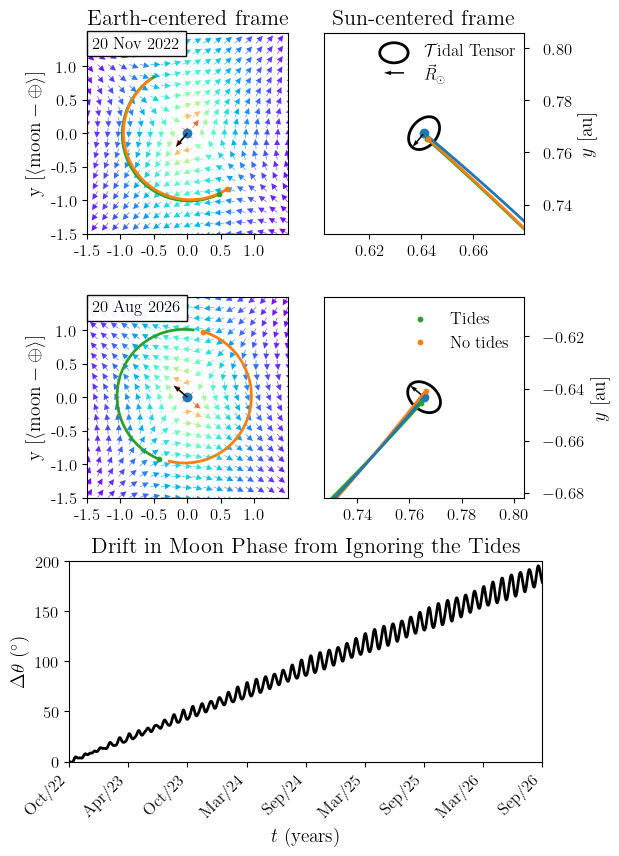

In [13]:
fig,axes= set_up_figure(nrows=3)
frame_index=100
sim_index= MTD.coordinate_frame_to_simulation_index(frame_index, t_eval, FRAMES_PER_UNIT_TIME)
down_index = sim_index - orbit_index_width
up_index = sim_index 
if down_index < 0:
    down_index = 0
if sim_index >=TOTAL_SIM_INDEXES:
    up_index = TOTAL_SIM_INDEXES - 1    

tidal_tensor,tidal_force,tidal_force_magnitude,centrifugalforce,centrifugalforce_magnitude,tidal_orbit,rotating_orbit= \
    calculate_frame_forces(sim_index, G_val, M_sun, Dearth, unscaled_tidal_tensor_func,
                            earthsOrbit, positions, omega_vec, tidal_solution, rotating_two_body_solution)
plot_frame_data(axes[0], sim_index, down_index,
                   tidal_orbit, rotating_orbit, 
                   inertial_tidal_solution, inertial_rotating_solution, earthsOrbit,
                   tidal_force, tidal_force_magnitude, colors_tidal,
                   X, Y, PROPERTIES)
#### ADD THE FICTICIOUS DATE TO THE PLOT
years_forward = t_eval[sim_index]
ficticious_date = ficticious_start_date + datetime.timedelta(days=365*years_forward)
ficticious_date_str = ficticious_date.strftime("%d %b %Y ")
axes[0][0].text(0.0275, 0.925, f"{ficticious_date_str}", transform=axes[0][0].transAxes, ha='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
axes[0][0].set_title("Earth-centered frame")
axes[0][1].set_title("Sun-centered frame")
axes[0][1].quiver(earthsOrbit[0,sim_index],earthsOrbit[1,sim_index],-earthsOrbit[0,sim_index],-earthsOrbit[1,sim_index],scale=11)
axes[0][0].quiver(0,0,-earthsOrbit[0,sim_index],-earthsOrbit[1,sim_index],scale=11,)

### GET THE TIDAL TENSOR 
rearth=np.linalg.norm(earthsOrbit[:, sim_index])
tensor_2d=unscaled_tidal_tensor_func(rearth, earthsOrbit[0, sim_index], earthsOrbit[1, sim_index], earthsOrbit[2, sim_index])
tensor_2d=tensor_2d[0:2, 0:2]
eigenvalues, eigenvectors = np.linalg.eigh(tensor_2d)
scale=1/100
width = scale * np.sqrt(np.abs(eigenvalues[0]))
height = scale * np.sqrt(np.abs(eigenvalues[1]))
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
ellipse = Ellipse(xy=earthsOrbit[0:2,sim_index], width=width, height=height, 
                    angle=angle, facecolor='none', edgecolor="k", linewidth=2,label=r"$\mathcal{T}$idal Tensor")
axes[0][1].add_patch(ellipse)


# create an ellipse for custom legend
xpos=0.35
ypos=0.9
scale=10
ellipse = Ellipse(xy=(xpos, ypos), width=scale*width, height=scale*height,
                    angle=90, facecolor='none', edgecolor="k", linewidth=2,
                    transform=axes[0][1].transAxes)
# Add the ellipse to the axes
axes[0][1].add_patch(ellipse)
# Create a custom legend handle for the tidal tensor
axes[0][1].text(xpos+0.15, ypos, r"$\mathcal{T}$idal Tensor", transform=axes[0][1].transAxes, ha='left', va="center", fontsize=12, )

### add label for R sun 
xpos=0.4
ypos=0.8
axes[0][1].quiver(xpos, ypos,  # x, y position in axis coordinates (0-1)
                 -0.1, 0,    # dx, dy (arrow direction)
                 scale=1,
                 transform=axes[0][1].transAxes)  # Use axis coordinates
axes[0][1].text(xpos+0.1, ypos, r"$\vec{R}_\odot$", transform=axes[0][1].transAxes, ha='left', va="center", fontsize=12, )




######################################################
################## THE SECOND FRAME ##################
######################################################
frame_index=2800
sim_index= MTD.coordinate_frame_to_simulation_index(frame_index, t_eval, FRAMES_PER_UNIT_TIME)
down_index = sim_index - orbit_index_width
up_index = sim_index 
if down_index < 0:
    down_index = 0
if sim_index >=TOTAL_SIM_INDEXES:
    up_index = TOTAL_SIM_INDEXES - 1    
tidal_tensor,tidal_force,tidal_force_magnitude,centrifugalforce,centrifugalforce_magnitude,tidal_orbit,rotating_orbit= \
    calculate_frame_forces(sim_index, G_val, M_sun, Dearth, unscaled_tidal_tensor_func,
                            earthsOrbit, positions, omega_vec, tidal_solution, rotating_two_body_solution)
plot_frame_data(axes[1], sim_index, down_index,
                   tidal_orbit, rotating_orbit, 
                   inertial_tidal_solution, inertial_rotating_solution, earthsOrbit,
                   tidal_force, tidal_force_magnitude, colors_tidal,
                   X, Y, PROPERTIES)

##### ADD THE DATE TO THE PLOT
years_forward = t_eval[sim_index]
ficticious_date = ficticious_start_date + datetime.timedelta(days=365*years_forward)
ficticious_date_str = ficticious_date.strftime("%d %b %Y ")
scale=1
axes[1][0].text(0.0275, 0.925, f"{ficticious_date_str}", transform=axes[1][0].transAxes, ha='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
axes[1][1].quiver(earthsOrbit[0,sim_index],earthsOrbit[1,sim_index],-earthsOrbit[0,sim_index],-earthsOrbit[1,sim_index],scale=11)
axes[1][0].quiver(0,0,-earthsOrbit[0,sim_index],-earthsOrbit[1,sim_index],scale=11)

### GET THE TIDAL TENSOR 
rearth=np.linalg.norm(earthsOrbit[:, sim_index])
tensor_2d=unscaled_tidal_tensor_func(rearth, earthsOrbit[0, sim_index], earthsOrbit[1, sim_index], earthsOrbit[2, sim_index])
tensor_2d=tensor_2d[0:2, 0:2]
eigenvalues, eigenvectors = np.linalg.eigh(tensor_2d)
scale=1/100
width = scale * np.sqrt(np.abs(eigenvalues[0]))
height = scale * np.sqrt(np.abs(eigenvalues[1]))
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
ellipse = Ellipse(xy=earthsOrbit[0:2,sim_index], width=width, height=height, 
                    angle=angle, facecolor='none', edgecolor="k", linewidth=2)
axes[1][1].add_patch(ellipse)


# # First create the legend as you normally would
legend = axes[1][1].legend(frameon=False)
# First get all artists that have labels
handles, labels = axes[1][1].get_legend_handles_labels()
# Skip the first three elements
handles = handles[0:2]
labels = labels[0:2]
# Create a new legend with only the elements you want
legend = axes[1][1].legend(handles, labels,frameon=False)


###### PLOT THE DIFFERENCE IN PHASE !!! 
nrows=3
axes[nrows-1].plot(t_eval, dphase, label='Tidal', color='black')
axes[nrows-1].set(**AXIS3);
axes[nrows-1].get_xticks()
##### MAKE THE TICKS YERAS !
ticks = axes[nrows-1].get_xticks()
tick_labels = []
# set the ticks at this positions
axes[nrows-1].set_xticks(ticks)
for tick in ticks:
    years_forward = tick
    ficticious_date = ficticious_start_date + datetime.timedelta(days=365*years_forward)
    ficticious_date_str = ficticious_date.strftime("%b/%y ")
    tick_labels.append(ficticious_date_str)
axes[nrows-1].set_xticklabels(tick_labels, rotation=45, ha='right')
axes[nrows-1].set_title("Drift in Moon Phase from Ignoring the Tides")
fig.tight_layout()
fig.savefig("../../images/"+"moon_tidal_simulation.png", dpi=300)

In [296]:
outdir+"moon_tidal_simulation.png"

'../frames/moon_tidal_simulation.png'

In [97]:
phase_tides = np.arctan2(tidal_solution.y[1], tidal_solution.y[0])
phase_rotating = np.arctan2(rotating_two_body_solution.y[1], rotating_two_body_solution.y[0])
phase_tides_unwrapped = np.unwrap(phase_tides)
phase_rotating_unwrapped = np.unwrap(phase_rotating)

# Spherical case
Try to show that the longest eigen vector of the tidal tensor will always align with the radial vector 

In [104]:
# Variables
x, y, z, G, M = sp.symbols('x y z G M')
r = sp.sqrt(x**2 + y**2 + z**2)

# Potential
Phi = -G*M/r

# Force = grad(Phi)
grad_Phi = [sp.diff(Phi, var) for var in (x, y, z)]

# Hessian (tidal tensor)
tidal_tensor = -sp.Matrix([
    [sp.diff(grad_Phi[i], var) for var in (x, y, z)]
    for i in range(3)
])

tidal_tensor

Matrix([
[3*G*M*x**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2), 3*G*M*y**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2), 3*G*M*z**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2)]])

Note that sympy is having a hard time doing all the algebraic manipulations, like finding the eigen vectors. I will simplify this expression to find the tidal tensor. This can be done by replacing $x^2 + y^2 + z^2$ with $r^2$ and factoring out  $\frac{GM}{r^3}$ This way, I can have a "scaled" tidal tensor.

Note that below I introduce $r$ without establishing that it is $r^2=x^2 + y^2 + z^2$. With SymPy, this manouver keeps the equation neat and orderly. 

In [105]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)
scaled_tidal_tensor

Matrix([
[-1 + 3*x**2/r**2,       3*x*y/r**2,       3*x*z/r**2],
[      3*x*y/r**2, -1 + 3*y**2/r**2,       3*y*z/r**2],
[      3*x*z/r**2,       3*y*z/r**2, -1 + 3*z**2/r**2]])

# Solve the equations of motion 
$$ \ddot{r}_\text{moon,earth} = -\nabla \Phi(r_\text{moon,earth})_{\text{Earth}} - T_\odot(r_\text{earth,sun}) \cdot \vec{r}_\text{moon,earth} - \vec{\omega} \times \left(\vec{\omega} \times {\vec{r}_{\text{moon,sun}}}\right)$$ 

We can use scipy's `solve_ivp`  since orbits are initial value problems of ordinary differential equations. Since I need to evaluate the position of the earth a function of time, the equations of motion will not be a set of autonomous differentia equations. They will depend on time 

In [106]:
from scipy import integrate

In [107]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")

def system_of_equations(t, y, G_val, Mearth, omega, Msun, scaled_tidal_tensor_func):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # get the current position of the earth
    x_earth = Dearth * np.cos(omega * t)
    y_earth = Dearth * np.sin(omega * t)
    z_earth = 0
    position_earth = np.array([x_earth, y_earth, z_earth])
    r_earth = np.linalg.norm(position_earth)
    # eval the tidal tensor at the position of the earth
    tidal_tensor = -(G_val*Msun/r_earth**3)*scaled_tidal_tensor_func(r_earth, position_earth[0], position_earth[1], position_earth[2])
    tidal_force = tidal_tensor.dot(position_moon)
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force = tidal_force + centrifugalforce + earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

def two_body_rotating_frame_system_of_equations(t, y, G_val, Mearth, omega):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force =  earth_force + centrifugalforce
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

def two_body_system_of_equations(t,y, G_val, Mearth):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force =   earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

In [108]:
# pick the initial conditions of the moon w.r.t. the earth
# build the initial conditions of the moon from https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
semi_major_axis = 0.3844 * 1e6 * u.km
eccentricity = 0.0549 
inclination = 5.145*u.deg
# convert the units
semi_major_axis=semi_major_axis.to(unitL).value
inclination=inclination.to(u.rad).value
# get the apogee
ra = (1+eccentricity) * semi_major_axis
# get the spped at apogee
v_apogee = np.sqrt(G_val*Mearth * (2/ra - 1/semi_major_axis))
# put them in vectors
position_moon = np.array([ra, 0, 0])
velocity_moon = np.array([0, v_apogee, 0])
# make a rotation matrix about the x-axis
rotation_matrix = np.array([[1, 0, 0],
                              [0, np.cos(inclination), -np.sin(inclination)],
                              [0, np.sin(inclination), np.cos(inclination)]])
# rotate the position and velocity vectors
position_moon = rotation_matrix.dot(position_moon)
velocity_moon = rotation_matrix.dot(velocity_moon)
# package the phase space coordinates
y0 = np.concatenate([position_moon, velocity_moon])

In [109]:
t_span = (0, 4) # two years 
rtol=1e-10
atol=1e-10
t_eval_n_points = 1000
t_eval=np.linspace(t_span[0], t_span[1], t_eval_n_points)
solution_all = integrate.solve_ivp(
    system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth, omega, 1, scaled_tidal_tensor_func), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)
solution_rotating = integrate.solve_ivp(
    two_body_rotating_frame_system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth, omega), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)
solution_two_body = integrate.solve_ivp(
    two_body_system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)

In [110]:
# get the phase angle for each 
phase_all = np.arctan2(solution_all.y[1], solution_all.y[0])
phase_rotating = np.arctan2(solution_rotating.y[1], solution_rotating.y[0])
phase_two_body = np.arctan2(solution_two_body.y[1], solution_two_body.y[0])
# unwrap the phase angles to avoid discontinuities at ±π
phase_all = np.unwrap(phase_all)
phase_rotating = np.unwrap(phase_rotating)
phase_two_body = np.unwrap(phase_two_body)

In [111]:
dphase=(180/np.pi)*(phase_rotating-phase_all)
AXIS = {
    "ylabel": r"$\Delta$ Moon Phase [degrees]",
    "xlabel": "Time [years]",
    "xlim": (0, 4),
    "ylim": (0, 180),
    "yticks": np.arange(0, 181, 30),
    "yticklabels": [f"{int(tick)}" for tick in np.arange(0, 181, 30)],
    "xticks": np.arange(0, 5, 1),
    "xticklabels": [f"{int(tick)}" for tick in np.arange(0, 5, 1)],
    "title": "Orbital Moon Drift due to the Sun's Tidal Forces",
}

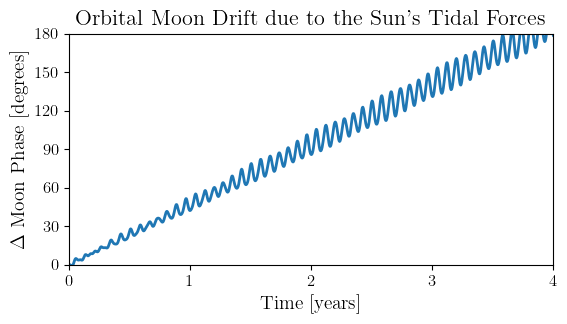

In [112]:
fig,axis=plt.subplots(figsize=(8.25-2, 3))
axis.plot(solution_all.t, dphase, label='x')
axis.set(**AXIS);